# Synthetic Data with interaction: recovery of relevant features

## SE1

### Data

In [1]:
from pyselect.data import jordan_se1
from ignite.utils import manual_seed

In [2]:
manual_seed(2000) # Visualization seed much higher to avoid biasing
X_se1, y_se1 = jordan_se1(rho=0.5)

Visualization

In [3]:
import matplotlib.pyplot as plt
plt.style.use("../figures/pyselect.mplstyle")

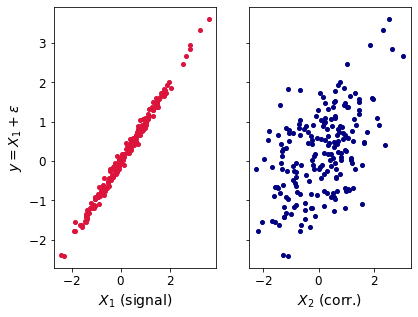

In [4]:
fig,(ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.plot(X_se1[:, 0], y_se1, 'o', markersize=4, color='crimson')
ax1.set_xlabel(r"$X_1$ (signal)")
ax1.set_ylabel(r"$y = X_1 + \epsilon$")
ax2.plot(X_se1[:, 1], y_se1, 'o', 
         markersize=4, color='navy')
ax2.set_xlabel("$X_2$ (corr.)")
plt.show()

### Model

In [5]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from optuna.samplers import TPESampler
from optuna.integration.pytorch_ignite import PyTorchIgnitePruningHandler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RootMeanSquaredError
from ignite.handlers import EarlyStopping, LRScheduler, BasicTimeProfiler
from pyselect.networks import RandomFourierFeaturesNet
from pyselect.data import train_val_test_split
from pyselect.train import ridge_loss, score_function, best_model_callback

Set train, validation and test sizes

In [6]:
train_size = 200
val_size = 100
test_size = 100

Generate data with $\rho = 0.5$

In [7]:
manual_seed(0)
X_se1, y_se1 = jordan_se1(n_samples=400, rho=0.5)

Data-splitting

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_se1, y_se1, train_size, val_size, test_size)

Generate datasets

In [9]:
train = torch.utils.data.TensorDataset(X_train, y_train)
val = torch.utils.data.TensorDataset(X_val, y_val)
test = torch.utils.data.TensorDataset(X_test, y_test)

Prepare dataloaders

In [10]:
train_loader = DataLoader(train, batch_size=train_size)
val_loader = DataLoader(val, batch_size=val_size)
test_loader = DataLoader(test, batch_size=test_size)

Objective for optuna

In [11]:
def objective(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    in_features = 2
    out_features = 50
    model = RandomFourierFeaturesNet(in_features, out_features, torch.randn) 
    model.to(device) 

    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    reg_param = trial.suggest_float("reg_param", 1e-7, 1e-4, log=True)
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, model, reg_param)
    
    trainer = create_supervised_trainer(model, optimizer, loss_fn, device)
    
    # Add learning rate scheduler
    step_size = len(train_loader)*n_epochs//2
    torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)
    scheduler = LRScheduler(torch_scheduler)
    trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
    val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)
    
    # Add pruner
    pruner = PyTorchIgnitePruningHandler(trial, 'loss', trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, pruner)

    # Loggers
    log_every = 200
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_training_results(engine):
        train_evaluator.run(train_loader)
        loss = train_evaluator.state.metrics['loss']
        print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_validation_results(engine):
        val_evaluator.run(val_loader)
        loss = val_evaluator.state.metrics['loss']
        print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_lr():
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        
    # Attach basic time profiler
    time_profiler = BasicTimeProfiler()
    time_profiler.attach(trainer)
    
    # Add early stopping 
    handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, handler) 
    
    # Train the model
    trainer.run(train_loader, max_epochs=n_epochs)
    
    # Save best model in study parameters
    trial.set_user_attr(key='best_model', value=model)    
    
    # Time evaluation
    profiling_results = time_profiler.get_results()
    trial.set_user_attr(key='time_profiling', value=profiling_results)
    
    # Final evaluation
    val_evaluator.run(val_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

Initalize optuna study

In [12]:
tpe_sampler = TPESampler(seed=0)

In [13]:
study = optuna.create_study(direction='minimize', sampler=tpe_sampler)

[I 2022-02-22 13:57:48,938] A new study created in memory with name: no-name-404a2327-d23a-4040-8e81-4d1fd2dcd29c


Run study

In [14]:
n_epochs = 1001

In [15]:
study.optimize(objective, n_trials=20, callbacks=[best_model_callback])

Training - Epoch: 200 Loss: 0.40805
Validation - Epoch: 200 Loss: 0.60596
Learning rate: 0.0125
Training - Epoch: 400 Loss: 0.15668
Validation - Epoch: 400 Loss: 0.34594
Learning rate: 0.0125
Training - Epoch: 600 Loss: 0.09575
Validation - Epoch: 600 Loss: 0.26798
Learning rate: 0.0063
Training - Epoch: 800 Loss: 0.07485
Validation - Epoch: 800 Loss: 0.23575
Learning rate: 0.0063


[I 2022-02-22 13:57:53,349] Trial 0 finished with value: 0.21193098068237304 and parameters: {'learning_rate': 0.012520653814999465, 'reg_param': 1.3981961408994034e-05}. Best is trial 0 with value: 0.21193098068237304.


Training - Epoch: 1000 Loss: 0.06153
Validation - Epoch: 1000 Loss: 0.21198
Learning rate: 0.0031
Training - Epoch: 200 Loss: 0.22134
Validation - Epoch: 200 Loss: 0.36043
Learning rate: 0.0161
Training - Epoch: 400 Loss: 0.07531
Validation - Epoch: 400 Loss: 0.18705
Learning rate: 0.0161
Training - Epoch: 600 Loss: 0.05056
Validation - Epoch: 600 Loss: 0.14406
Learning rate: 0.0080
Training - Epoch: 800 Loss: 0.04234
Validation - Epoch: 800 Loss: 0.12669
Learning rate: 0.0080


[I 2022-02-22 13:57:55,280] Trial 1 finished with value: 0.11406346321105958 and parameters: {'learning_rate': 0.01605191133358762, 'reg_param': 4.311710058685494e-06}. Best is trial 1 with value: 0.11406346321105958.


Training - Epoch: 1000 Loss: 0.03699
Validation - Epoch: 1000 Loss: 0.11409
Learning rate: 0.0040
Training - Epoch: 200 Loss: 0.79080
Validation - Epoch: 200 Loss: 0.97235
Learning rate: 0.0070
Training - Epoch: 400 Loss: 0.69312
Validation - Epoch: 400 Loss: 0.87120
Learning rate: 0.0070
Training - Epoch: 600 Loss: 0.50530
Validation - Epoch: 600 Loss: 0.68328
Learning rate: 0.0035
Training - Epoch: 800 Loss: 0.38453
Validation - Epoch: 800 Loss: 0.55946
Learning rate: 0.0035


[I 2022-02-22 13:57:57,334] Trial 2 finished with value: 0.45865459442138673 and parameters: {'learning_rate': 0.00703573702872215, 'reg_param': 8.66327976135455e-06}. Best is trial 1 with value: 0.11406346321105958.


Training - Epoch: 1000 Loss: 0.29153
Validation - Epoch: 1000 Loss: 0.45887
Learning rate: 0.0018
Training - Epoch: 200 Loss: 0.76252
Validation - Epoch: 200 Loss: 0.94190
Learning rate: 0.0075
Training - Epoch: 400 Loss: 0.56582
Validation - Epoch: 400 Loss: 0.72487
Learning rate: 0.0075
Training - Epoch: 600 Loss: 0.38970
Validation - Epoch: 600 Loss: 0.56044
Learning rate: 0.0038
Training - Epoch: 800 Loss: 0.29417
Validation - Epoch: 800 Loss: 0.47777
Learning rate: 0.0038


[I 2022-02-22 13:57:59,195] Trial 3 finished with value: 0.4154015350341797 and parameters: {'learning_rate': 0.007501954443620123, 'reg_param': 4.7349893044994796e-05}. Best is trial 1 with value: 0.11406346321105958.


Training - Epoch: 1000 Loss: 0.22322
Validation - Epoch: 1000 Loss: 0.41553
Learning rate: 0.0019
Training - Epoch: 200 Loss: 0.03854
Validation - Epoch: 200 Loss: 0.13539
Learning rate: 0.0846
Training - Epoch: 400 Loss: 0.02395
Validation - Epoch: 400 Loss: 0.09115
Learning rate: 0.0846
Training - Epoch: 600 Loss: 0.02059
Validation - Epoch: 600 Loss: 0.07782
Learning rate: 0.0423
Training - Epoch: 800 Loss: 0.01925
Validation - Epoch: 800 Loss: 0.07195
Learning rate: 0.0423


[I 2022-02-22 13:58:01,476] Trial 4 finished with value: 0.06742177963256836 and parameters: {'learning_rate': 0.08459126528049378, 'reg_param': 1.4135935551752292e-06}. Best is trial 4 with value: 0.06742177963256836.


Training - Epoch: 1000 Loss: 0.01829
Validation - Epoch: 1000 Loss: 0.06743
Learning rate: 0.0211
Training - Epoch: 200 Loss: 0.07375
Validation - Epoch: 200 Loss: 0.26234
Learning rate: 0.0383
Training - Epoch: 400 Loss: 0.03134
Validation - Epoch: 400 Loss: 0.15870
Learning rate: 0.0383
Training - Epoch: 600 Loss: 0.02472
Validation - Epoch: 600 Loss: 0.12783
Learning rate: 0.0192
Training - Epoch: 800 Loss: 0.02242
Validation - Epoch: 800 Loss: 0.11476
Learning rate: 0.0192


[I 2022-02-22 13:58:03,513] Trial 5 finished with value: 0.1049844741821289 and parameters: {'learning_rate': 0.03832216850492789, 'reg_param': 3.860866271460544e-06}. Best is trial 4 with value: 0.06742177963256836.


Training - Epoch: 1000 Loss: 0.02087
Validation - Epoch: 1000 Loss: 0.10501
Learning rate: 0.0096


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 13:58:03,890] Trial 6 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 0.36933


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 13:58:04,386] Trial 7 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 0.80893


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 13:58:04,924] Trial 8 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 0.80789
Training - Epoch: 200 Loss: 0.10351
Validation - Epoch: 200 Loss: 0.27682
Learning rate: 0.0360
Training - Epoch: 400 Loss: 0.03558
Validation - Epoch: 400 Loss: 0.14586
Learning rate: 0.0360
Training - Epoch: 600 Loss: 0.02709
Validation - Epoch: 600 Loss: 0.11538
Learning rate: 0.0180
Training - Epoch: 800 Loss: 0.02427
Validation - Epoch: 800 Loss: 0.10307
Learning rate: 0.0180


[I 2022-02-22 13:58:07,121] Trial 9 finished with value: 0.09404838562011719 and parameters: {'learning_rate': 0.0360009119291161, 'reg_param': 4.074144654166234e-05}. Best is trial 4 with value: 0.06742177963256836.


Training - Epoch: 1000 Loss: 0.02241
Validation - Epoch: 1000 Loss: 0.09407
Learning rate: 0.0090
Training - Epoch: 200 Loss: 0.02864
Validation - Epoch: 200 Loss: 0.12891
Learning rate: 0.0857
Training - Epoch: 400 Loss: 0.01953
Validation - Epoch: 400 Loss: 0.08589
Learning rate: 0.0857
Training - Epoch: 600 Loss: 0.01743
Validation - Epoch: 600 Loss: 0.07244
Learning rate: 0.0428
Training - Epoch: 800 Loss: 0.01659
Validation - Epoch: 800 Loss: 0.06644
Learning rate: 0.0428


[I 2022-02-22 13:58:09,043] Trial 10 finished with value: 0.06179626941680908 and parameters: {'learning_rate': 0.08568943001593249, 'reg_param': 5.773457334097196e-07}. Best is trial 10 with value: 0.06179626941680908.


Training - Epoch: 1000 Loss: 0.01598
Validation - Epoch: 1000 Loss: 0.06181
Learning rate: 0.0214
Training - Epoch: 200 Loss: 0.03871
Validation - Epoch: 200 Loss: 0.11827
Learning rate: 0.0805
Training - Epoch: 400 Loss: 0.02273
Validation - Epoch: 400 Loss: 0.07692
Learning rate: 0.0805
Training - Epoch: 600 Loss: 0.01950
Validation - Epoch: 600 Loss: 0.06503
Learning rate: 0.0402
Training - Epoch: 800 Loss: 0.01826
Validation - Epoch: 800 Loss: 0.05984
Learning rate: 0.0402


[I 2022-02-22 13:58:11,126] Trial 11 finished with value: 0.055857877731323245 and parameters: {'learning_rate': 0.08045564515992583, 'reg_param': 5.271425624171629e-07}. Best is trial 11 with value: 0.055857877731323245.


Training - Epoch: 1000 Loss: 0.01737
Validation - Epoch: 1000 Loss: 0.05587
Learning rate: 0.0201
Training - Epoch: 200 Loss: 0.02872
Validation - Epoch: 200 Loss: 0.11065
Learning rate: 0.0919
Training - Epoch: 400 Loss: 0.01944
Validation - Epoch: 400 Loss: 0.07524
Learning rate: 0.0919
Training - Epoch: 600 Loss: 0.01728
Validation - Epoch: 600 Loss: 0.06446
Learning rate: 0.0460
Training - Epoch: 800 Loss: 0.01642
Validation - Epoch: 800 Loss: 0.05965
Learning rate: 0.0460


[I 2022-02-22 13:58:13,120] Trial 12 finished with value: 0.055901618003845216 and parameters: {'learning_rate': 0.09190131112923958, 'reg_param': 4.6050978490366747e-07}. Best is trial 11 with value: 0.055857877731323245.


Training - Epoch: 1000 Loss: 0.01580
Validation - Epoch: 1000 Loss: 0.05591
Learning rate: 0.0230
Training - Epoch: 200 Loss: 0.09513
Validation - Epoch: 200 Loss: 0.24750
Learning rate: 0.0415
Training - Epoch: 400 Loss: 0.04201
Validation - Epoch: 400 Loss: 0.14738
Learning rate: 0.0415
Training - Epoch: 600 Loss: 0.03205
Validation - Epoch: 600 Loss: 0.12038
Learning rate: 0.0208


Engine run is terminating due to exception: Trial was pruned at 800 epoch.
Engine run is terminating due to exception: Trial was pruned at 800 epoch.
[I 2022-02-22 13:58:14,765] Trial 13 pruned. Trial was pruned at 800 epoch.


Training - Epoch: 800 Loss: 0.02843
Training - Epoch: 200 Loss: 0.02926
Validation - Epoch: 200 Loss: 0.11538
Learning rate: 0.0985
Training - Epoch: 400 Loss: 0.01963
Validation - Epoch: 400 Loss: 0.07803
Learning rate: 0.0985
Training - Epoch: 600 Loss: 0.01747
Validation - Epoch: 600 Loss: 0.06659
Learning rate: 0.0493
Training - Epoch: 800 Loss: 0.01661
Validation - Epoch: 800 Loss: 0.06148
Learning rate: 0.0493


[I 2022-02-22 13:58:16,606] Trial 14 finished with value: 0.05750743865966797 and parameters: {'learning_rate': 0.0985330508762059, 'reg_param': 6.541086102886736e-07}. Best is trial 11 with value: 0.055857877731323245.


Training - Epoch: 1000 Loss: 0.01599
Validation - Epoch: 1000 Loss: 0.05752
Learning rate: 0.0246


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 13:58:16,978] Trial 15 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 0.80623
Training - Epoch: 200 Loss: 0.08490
Validation - Epoch: 200 Loss: 0.21798
Learning rate: 0.0279
Training - Epoch: 400 Loss: 0.03756
Validation - Epoch: 400 Loss: 0.12651
Learning rate: 0.0279
Training - Epoch: 600 Loss: 0.02883
Validation - Epoch: 600 Loss: 0.10225
Learning rate: 0.0140
Training - Epoch: 800 Loss: 0.02569
Validation - Epoch: 800 Loss: 0.09226
Learning rate: 0.0140


[I 2022-02-22 13:58:18,837] Trial 16 finished with value: 0.0848723030090332 and parameters: {'learning_rate': 0.027914003168179154, 'reg_param': 1.361868613426722e-06}. Best is trial 11 with value: 0.055857877731323245.


Training - Epoch: 1000 Loss: 0.02356
Validation - Epoch: 1000 Loss: 0.08489
Learning rate: 0.0070
Training - Epoch: 200 Loss: 0.04620
Validation - Epoch: 200 Loss: 0.15552
Learning rate: 0.0496
Training - Epoch: 400 Loss: 0.02591
Validation - Epoch: 400 Loss: 0.09766
Learning rate: 0.0496
Training - Epoch: 600 Loss: 0.02167
Validation - Epoch: 600 Loss: 0.08131
Learning rate: 0.0248
Training - Epoch: 800 Loss: 0.02004
Validation - Epoch: 800 Loss: 0.07432
Learning rate: 0.0248


[I 2022-02-22 13:58:20,829] Trial 17 finished with value: 0.06903366088867187 and parameters: {'learning_rate': 0.049622270716823805, 'reg_param': 1.0078641760003064e-07}. Best is trial 11 with value: 0.055857877731323245.


Training - Epoch: 1000 Loss: 0.01890
Validation - Epoch: 1000 Loss: 0.06905
Learning rate: 0.0124


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 13:58:21,193] Trial 18 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 0.11970
Training - Epoch: 200 Loss: 0.03675
Validation - Epoch: 200 Loss: 0.10172
Learning rate: 0.0613
Training - Epoch: 400 Loss: 0.02309
Validation - Epoch: 400 Loss: 0.06905
Learning rate: 0.0613
Training - Epoch: 600 Loss: 0.01998
Validation - Epoch: 600 Loss: 0.05935
Learning rate: 0.0307
Training - Epoch: 800 Loss: 0.01875
Validation - Epoch: 800 Loss: 0.05507
Learning rate: 0.0307


[I 2022-02-22 13:58:23,177] Trial 19 finished with value: 0.05177423477172852 and parameters: {'learning_rate': 0.06130691967328132, 'reg_param': 3.236437288705266e-07}. Best is trial 19 with value: 0.05177423477172852.


Training - Epoch: 1000 Loss: 0.01786
Validation - Epoch: 1000 Loss: 0.05178
Learning rate: 0.0153


Get best model

In [16]:
best_model = study.user_attrs['best_model']

In [17]:
torch.save(best_model.state_dict(), '../models/jordan-se1.pth')

Replicate best model on different test datasets

In [18]:
def replicate(trial):
    # Set replication seed
    seed = trial.number + 1000
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    X_test, y_test = jordan_se1(n_samples=test_size, rho=0.5)
    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=test_size)
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    reg_param = study.best_params['reg_param']
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, best_model, reg_param)
    
    best_model.to(device) 
        
    # Add evaluators
    test_metric = {'rmse': RootMeanSquaredError()}    
    test_evaluator = create_supervised_evaluator(best_model, metrics=test_metric, device=device)
    
    # Final evaluation
    test_evaluator.run(test_loader)
    test_rmse = test_evaluator.state.metrics['rmse']
    
    return test_rmse

In [19]:
replication = optuna.create_study(direction='minimize')

[I 2022-02-22 13:58:23,211] A new study created in memory with name: no-name-204a8ec1-e6ce-4cdc-b060-c9c55fec3300


In [20]:
replication.optimize(replicate, n_trials=30)

[I 2022-02-22 13:58:23,224] Trial 0 finished with value: 0.15617191652466306 and parameters: {}. Best is trial 0 with value: 0.15617191652466306.
[I 2022-02-22 13:58:23,229] Trial 1 finished with value: 0.13244698435517385 and parameters: {}. Best is trial 1 with value: 0.13244698435517385.
[I 2022-02-22 13:58:23,233] Trial 2 finished with value: 0.16443641559586897 and parameters: {}. Best is trial 1 with value: 0.13244698435517385.
[I 2022-02-22 13:58:23,238] Trial 3 finished with value: 0.24593308790192422 and parameters: {}. Best is trial 1 with value: 0.13244698435517385.
[I 2022-02-22 13:58:23,243] Trial 4 finished with value: 0.28117700265256174 and parameters: {}. Best is trial 1 with value: 0.13244698435517385.
[I 2022-02-22 13:58:23,247] Trial 5 finished with value: 0.1161054988784425 and parameters: {}. Best is trial 5 with value: 0.1161054988784425.
[I 2022-02-22 13:58:23,251] Trial 6 finished with value: 0.16055603001241014 and parameters: {}. Best is trial 5 with value: 0

In [21]:
replication.trials_dataframe()['value'].mean()

0.15999634480695857

In [22]:
replication.trials_dataframe()['value'].std()

0.043092639590905576

### Visualization

##### Bands

In [23]:
import numpy as np

In [24]:
bands = best_model.rff_net[0].bandwidths.detach().to('cpu').numpy()
indexes = np.arange(1, 3)

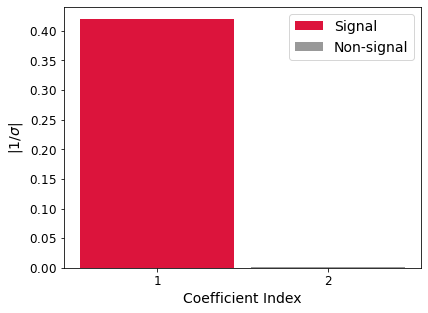

In [25]:
plt.bar(indexes[0], np.abs(bands)[0], width=0.9, color='crimson', label='Signal')
plt.bar(indexes[1], np.abs(bands)[1], width=0.9, color='black', alpha=0.4, label='Non-signal')
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
ax.set_xticks([1, 2])
plt.legend()
plt.show()

##### Predictions on test

In [26]:
best_model.to('cpu')

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=2)
    (1): RandomFourierFeaturesLayer(in_features=2, out_features=50)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

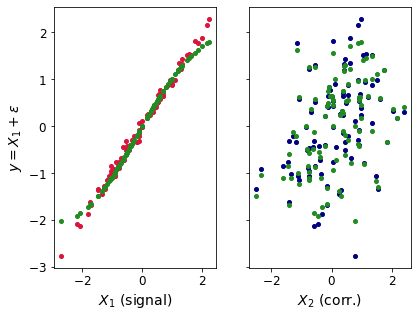

In [27]:
fig,(ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.plot(X_test[:, 0], y_test, 'o', markersize=4, color='crimson')
ax1.plot(X_test[:, 0], best_model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
ax1.set_xlabel(r"$X_1$ (signal)")
ax1.set_ylabel(r"$y = X_1 + \epsilon$")
ax2.plot(X_test[:, 1], y_test, 'o', markersize=4, color='navy')
ax2.set_xlabel("$X_2$ (corr.)")
ax2.plot(X_test[:, 1], best_model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
plt.show()

In [28]:
sorted_y_test = y_test.squeeze().sort(dim=0)[0].numpy()

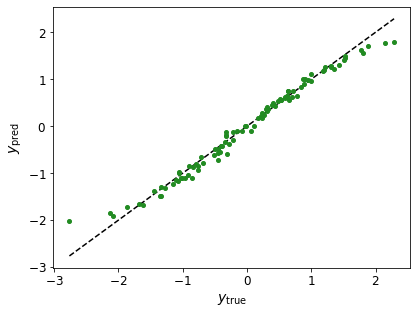

In [29]:
plt.plot(y_test, best_model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
plt.plot(sorted_y_test, sorted_y_test, color='k', linestyle='dashed', zorder=-10)
plt.xlabel(r"$y_{\mathrm{true}}$")
plt.ylabel(r"$y_{\mathrm{pred}}$")
plt.show()